# OSNAP line Lagrangian particle tracking investigation of the cold/fresh blob


### The aim here is an investigation of the source of the cold/fresh blob which appeared in the near-surface Iceland Basin from about 2014. There are a couple of published explanations for the feature: 

- reduced heat/salt transport across RAPID array and northwards to subpolar N Atlantic over several years (Bryden et al. 2020?) or 
- increased contribution from Labrador Sea water flowing into subpolar North Atlantic rather than southwards (Holliday et al. 2020?). Driven I think by specific,  more intermittent, weather near Flemish Cap (though I need to read this again...)

The technique is to track particles back from the OSNAP line for 4 years and identify those which came from the Gulf Stream and those which came through the Labrador Sea. And see how that changes between from 2006 to 2017. (Elsewhere I have done backwards particle tracking for all years between 2006 and 2017. This supports the results shown here and adds some detail, but 2 years tracking isn't really long enough to identify pathways). I am also trying to quantify the volume/heat/salt transports along each route (not here yet though).

## This notebook plots out the tracks and implements some source tests

## Technical preamble

In [1]:
%matplotlib inline

In [2]:
import os as os
os.environ['HTTP_PROXY']="http://www-cache.geomar.de:8080"
os.environ['HTTPS_PROXY']="https://www-cache.geomar.de:8080"

In [3]:
# import matplotlib.colors as colors
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns
# from matplotlib.colors import ListedColormap
import cmocean as co
import pandas as pd
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy
# import seawater as sw

from matplotlib import colors as c
from matplotlib import ticker
from xhistogram.xarray import histogram

In [4]:
sns.set(style="darkgrid")

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

sns.set_palette("colorblind")
xr.set_options(keep_attrs=True);

plt.rc('font', size=20) #controls default text size
plt.rc('axes', titlesize=20) #fontsize of the title
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
plt.rc('legend', fontsize=20) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

## Set up paths and read in trajectory data

In [19]:
## Parameters
# Project path
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

# output figures path
figures_path = Path("reports/figures/ColdBlob/")

# Parcels track data file
path_data_tracks = Path('data/processed/tracks/labradorCurrent/') 
filename_tracks = [
                   
                   'tracks_randomvel_lc_forwards_201001_N2492_D1825_Rnd123.nc'
]

# model mask file
data_path = Path("data/external/iAtlantic/")
experiment_name = "VIKING20X.L46-KKG36107B"
mesh_mask_file = project_path / data_path / "mask" / experiment_name / "1_mesh_mask.nc"

#section lonlat file
sectionPath = Path('data/external/sections/')
sectionFilename = 'lc_pos_wp.txt'
sectionname = 'labradorcurrent'

degree2km = 1.852*60.0

# some transport values specific to osnap runs
# randomly seeded 39995 particles, 19886 were in ocean points (the rest were land)

lc_section_length = 409381.17216899195    # m
lc_subsection_length = 409381.17216899195   # m
lc_section_depth = 3500 # m over which particles launched
lc_subsection_depth = 3500 # m over which particles launched

lc_ocean_area = lc_subsection_length * lc_subsection_depth * 16364 / 80000

particle_section_area = lc_subsection_length * lc_subsection_depth / 80000
max_current = 1.0



## Load data

### mesh and masks

In [12]:
mesh_mask = xr.open_dataset(mesh_mask_file)
mesh_mask = mesh_mask.squeeze()
mesh_mask = mesh_mask.set_coords(["nav_lon", "nav_lat", "nav_lev"])

bathy = mesh_mask.mbathy.rename("number of water filled points")

depth = (mesh_mask.e3t_0 * mesh_mask.tmask).sum("z")
# display(mesh_mask)

In [13]:
mesh_mask.gdepw_0[:,0,0]


<xarray.DataArray 'gdepw_0' (z: 46)>
array([   0.      ,    6.194242,   12.839149,   20.04454 ,   27.946293,
         36.712124,   46.548466,   57.708504,   70.50136 ,   85.30241 ,
        102.56431 ,  122.82839 ,  146.73515 ,  175.03276 ,  208.58119 ,
        248.3496  ,  295.4039  ,  350.88147 ,  415.9509  ,  491.7565  ,
        579.3501  ,  679.6166  ,  793.2019  ,  920.4562  , 1061.4005  ,
       1215.7251  , 1382.8185  , 1561.822   , 1751.701   , 1951.3186  ,
       2159.5059  , 2375.1194  , 2597.082   , 2824.4119  , 3056.2346  ,
       3291.788   , 3530.419   , 3771.574   , 4014.7896  , 4259.681   ,
       4505.9326  , 4753.283   , 5001.522   , 5250.476   , 5500.0063  ,
       5750.      ], dtype=float32)
Coordinates:
    nav_lon  float32 ...
    nav_lat  float32 ...
    nav_lev  (z) float32 ...
Dimensions without coordinates: z
Attributes:
    cell_methods:  t: mean

### section position data

In [14]:
lonlat = xr.Dataset(
    pd.read_csv(project_path / sectionPath / sectionFilename,delim_whitespace=True)
)

In [15]:
lonlat.lon.attrs['long_name']='Longitude'
lonlat.lat.attrs['long_name']='Latitude'
lonlat.lon.attrs['standard_name']='longitude'
lonlat.lat.attrs['standard_name']='latitude'
lonlat.lon.attrs['units']='degrees_east'
lonlat.lat.attrs['units']='degrees_north'

lonlat2mean= lonlat.rolling({'dim_0':2}).mean()

lonlatdiff = (lonlat.diff('dim_0'))

lonlatdiff = lonlatdiff.assign({'y':lonlatdiff['lat']*degree2km})
lonlatdiff = lonlatdiff.assign({'x':lonlatdiff['lon']
                                    *degree2km
                                    *np.cos(np.radians(lonlat2mean.lat.data[1:]))
                               })
lonlatdiff=lonlatdiff.assign({'length':np.sqrt(lonlatdiff['x']**2+lonlatdiff['y']**2)})
lonlatdiff=lonlatdiff.assign({'costheta':lonlatdiff['x']/lonlatdiff['length']})
lonlatdiff=lonlatdiff.assign({'sintheta':lonlatdiff['y']/lonlatdiff['length']})

total_length = lonlatdiff.length.sum().data 

length_west = xr.concat((xr.DataArray([0],
                                      dims=("dim_0"),
                                      coords={"dim_0": [0]}),
                         lonlatdiff.length.cumsum()),
                        dim='dim_0')

In [16]:
total_length

array(409.38117217)

In [17]:
lonlatdiff

<xarray.Dataset>
Dimensions:   (dim_0: 1)
Coordinates:
  * dim_0     (dim_0) int64 1
Data variables:
    lat       (dim_0) float64 2.3
    lon       (dim_0) float64 4.95
    y         (dim_0) float64 255.6
    x         (dim_0) float64 319.8
    length    (dim_0) float64 409.4
    costheta  (dim_0) float64 0.7812
    sintheta  (dim_0) float64 0.6243

### tracks

In [22]:
for i,filename in enumerate(filename_tracks):
    dst=xr.open_dataset(project_path / path_data_tracks / filename,chunks={"traj":10000})
    if i == 0:
        ds=dst.isel(obs=slice(0,None,1))
    else:
        ds=xr.concat([ds,dst.isel(obs=slice(0,1796,1))],dim='traj')


In [23]:
ds

<xarray.Dataset>
Dimensions:     (obs: 1826, traj: 2492)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 dask.array<chunksize=(2492, 1826), meta=np.ndarray>
    time        (traj, obs) datetime64[ns] dask.array<chunksize=(2492, 1826), meta=np.ndarray>
    lat         (traj, obs) float64 dask.array<chunksize=(2492, 1826), meta=np.ndarray>
    lon         (traj, obs) float64 dask.array<chunksize=(2492, 1826), meta=np.ndarray>
    z           (traj, obs) float64 dask.array<chunksize=(2492, 1826), meta=np.ndarray>
    temp        (traj, obs) float32 dask.array<chunksize=(2492, 1826), meta=np.ndarray>
    salt        (traj, obs) float32 dask.array<chunksize=(2492, 1826), meta=np.ndarray>
    uvel        (traj, obs) float32 dask.array<chunksize=(2492, 1826), meta=np.ndarray>
    vvel        (traj, obs) float32 dask.array<chunksize=(2492, 1826), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2
    parcels_mesh:           spherical

#### Subset tracks by OSNAP line cross longitude and depth range

In [24]:
# lonRange=[-100,0]
# depthRange=[0,1500]

# ds = ds.where((ds.isel(obs=0).lon > lonRange[0]) & (ds.isel(obs=0).lon < lonRange[1]))
# ds = ds.where((ds.isel(obs=0).z > depthRange[0]) & (ds.isel(obs=0).z < depthRange[1]))
# ds = ds.dropna('traj', how='all')
    

In [25]:
ds=ds.assign({'uvel_ms':ds.uvel * degree2km * 1000.0 * np.cos(np.radians(ds.lat))})
ds=ds.assign({'vvel_ms':ds.vvel * degree2km * 1000.0})

#### Extract fields on osnap line (obs=0). Find 'initial' velocities normal to the section.

These are the positions we 'initialised' the particles with, but we ran particles backwards in time so these  represent the final positions, on the osnap line.

In [26]:
ds_init = ds.isel(obs=0).compute()

In [27]:
ds_init


<xarray.Dataset>
Dimensions:     (traj: 2492)
Dimensions without coordinates: traj
Data variables:
    trajectory  (traj) float64 51.0 71.0 85.0 ... 7.996e+04 7.996e+04 7.997e+04
    time        (traj) datetime64[ns] 2010-01-16T12:00:00 ... 2010-01-16T12:0...
    lat         (traj) float64 55.2 55.34 55.24 55.34 ... 55.2 55.11 55.25 55.43
    lon         (traj) float64 -53.76 -53.47 -53.68 ... -53.96 -53.65 -53.26
    z           (traj) float64 81.0 495.1 344.4 349.1 ... 173.4 2.322e+03 237.6
    temp        (traj) float32 4.401 4.323 4.495 4.344 ... 4.712 3.177 4.17
    salt        (traj) float32 34.87 34.97 34.94 34.94 ... 34.86 34.98 34.91
    uvel        (traj) float32 6.998e-06 2.789e-06 ... 3.142e-06 1.981e-06
    vvel        (traj) float32 -2.118e-06 -1.085e-06 ... -1.195e-06 -9.283e-07
    uvel_ms     (traj) float64 0.4438 0.1763 0.3083 ... 0.4591 0.199 0.1249
    vvel_ms     (traj) float32 -0.2354 -0.1206 -0.1695 ... -0.1328 -0.1031
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2
    parcels_mesh:           spherical

In [28]:
ds_init = ds_init.assign(
                    {'section_index':
                     xr.DataArray(np.searchsorted(lonlat.lon,ds_init.lon)-1,
                                  dims='traj'
                                 )
                    }
)
ds_init = ds_init.assign(
                    {'u_normal':
                     ds_init.vvel_ms * lonlatdiff.costheta[ds_init.section_index].data - 
                     ds_init.uvel_ms * lonlatdiff.sintheta[ds_init.section_index].data
                    }
)
ds_init = ds_init.assign(
                    {'u_along':
                     ds_init.vvel_ms * lonlatdiff.sintheta[ds_init.section_index].data + 
                     ds_init.uvel_ms * lonlatdiff.costheta[ds_init.section_index].data
                    }
)


#### Find along-section distances of initial points

In [29]:
ds_init = ds_init.assign(
                    {'x':
                     xr.DataArray(length_west[ds_init.section_index] + 
                                  lonlatdiff.length[ds_init.section_index] *
                                  (ds_init.lon - lonlat.lon[ds_init.section_index]) /
                                  lonlatdiff.lon[ds_init.section_index],
                                  dims='traj'
                                 )
                    }
)

### volume, temperature and salt transports along track

In [30]:
# at osnap line
ds_init = ds_init.assign({'vol_trans_normal':np.sign(ds_init.u_normal) * 
                                              max_current * particle_section_area/1.0e06})
ds_init = ds_init.assign({'temp_transport':ds_init.temp * ds_init.vol_trans_normal})
ds_init = ds_init.assign({'salt_transport':ds_init.salt * ds_init.vol_trans_normal})
ds_init = ds_init.assign({'depth_transport':ds_init.z * ds_init.vol_trans_normal})
ds_init = ds_init.assign({'lon_transport':ds_init.lon * ds_init.vol_trans_normal})
ds_init = ds_init.assign({'particle_vol':ds_init.vol_trans_normal/ds_init.u_normal})
ds_init = ds_init.assign({'tempxvol':ds_init.temp * ds_init.particle_vol})
ds_init = ds_init.assign({'saltxvol':ds_init.salt * ds_init.particle_vol})
ds_init = ds_init.assign({'depthxvol':ds_init.z * ds_init.particle_vol})
ds_init = ds_init.assign({'lonxvol':ds_init.lon * ds_init.particle_vol})

# full track assuming alongtrack volume transport conserved following particle
ds = ds.assign({'temp_transport':ds.temp * ds_init.vol_trans_normal})
ds = ds.assign({'salt_transport':ds.salt * ds_init.vol_trans_normal})
ds = ds.assign({'vol_transport':ds_init.vol_trans_normal * ds.salt/ds.salt}) # trick to get full array dimensions

In [31]:
ds_init

<xarray.Dataset>
Dimensions:           (traj: 2492)
Dimensions without coordinates: traj
Data variables: (12/25)
    trajectory        (traj) float64 51.0 71.0 85.0 ... 7.996e+04 7.997e+04
    time              (traj) datetime64[ns] 2010-01-16T12:00:00 ... 2010-01-1...
    lat               (traj) float64 55.2 55.34 55.24 ... 55.11 55.25 55.43
    lon               (traj) float64 -53.76 -53.47 -53.68 ... -53.65 -53.26
    z                 (traj) float64 81.0 495.1 344.4 ... 173.4 2.322e+03 237.6
    temp              (traj) float32 4.401 4.323 4.495 ... 4.712 3.177 4.17
    ...                ...
    lon_transport     (traj) float64 0.9629 0.9576 0.9615 ... 0.9609 0.954
    particle_vol      (traj) float64 0.03886 0.08769 0.05513 ... 0.07855 0.113
    tempxvol          (traj) float64 0.171 0.3791 0.2478 ... 0.1827 0.2496 0.471
    saltxvol          (traj) float64 1.355 3.066 1.926 ... 1.351 2.748 3.944
    depthxvol         (traj) float64 3.148 43.41 18.98 ... 6.722 182.4 26.84
    lonxvol           (traj) float64 -2.089 -4.689 -2.959 ... -4.214 -6.016
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2
    parcels_mesh:           spherical

## Plot section

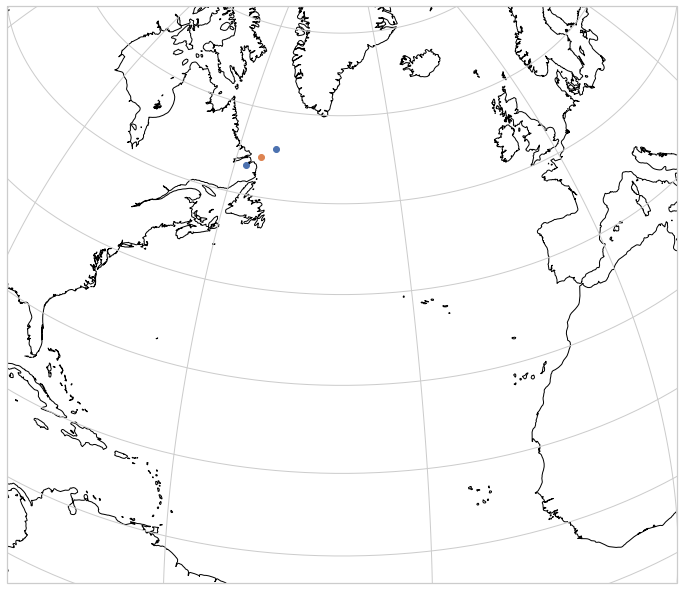

In [32]:
sns.set(style="whitegrid")
central_lon, central_lat = -40, 40
fig, ax = plt.subplots(
                figsize = (12,12),
                subplot_kw={'projection': ccrs.Orthographic(central_lon, central_lat)}
                )
extent = [-80, 0, 5, 70]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')

lonlat.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat')
lonlat2mean.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat');

## plot tracks by destination region

In [33]:
def apply_left_of_line(ds, lon_1, lon_2, lat_1, lat_2):
    '''Apply an area crossing criterion.
    
    Larvae in ds selected while they are in a selected area.
    '''
    # particles are selected if they pass through given area.
    position =  ((lon_2 -lon_1) * (ds.lat - lat_1) - 
                     (ds.lon - lon_1) * (lat_2 - lat_1))
                        
    return position > 0.0, position < 0

In [34]:
# range of stations from west to east, stations 0-12. Python indexing.

def plotTracksCartopy(ds1,
                      cmap=co.cm.tempo_r,
                      title='',
                      fig_path = Path.cwd(),
                      fileroot='',
                      date = ''
                     ):
    
    central_lon, central_lat = -40, 40
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(
                    figsize = (12,12),
                    subplot_kw={'projection': ccrs.Orthographic(central_lon, central_lat)}
                    )
    extent = [-80, 0, 5, 70]
    ax.set_extent(extent)
    ax.gridlines()
    ax.coastlines(resolution='50m')
    
    dsmask = ds1

    pcm = ax.scatter(
        dsmask.lon.data.flatten(),
        dsmask.lat.data.flatten(),
        3,
        mdates.date2num(dsmask.time.data.flatten())
#         dsmask.z.data.flatten()
        ,cmap= cmap
        ,zorder=2
        ,transform=ccrs.PlateCarree()
    #   ,alpha=0.3
    )
    cb = fig.colorbar(pcm,ax=ax,shrink=0.8,label = "date")
    loc = mdates.MonthLocator(bymonth=range(1,13,3))
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
#     cb.ax.tick_params(labelsize=20)


    depth.isel(y=slice(0, 2499), x=slice(0, 2404)).plot.contour(
                        ax=ax,
                        transform=ccrs.PlateCarree(),
                        x="nav_lon", 
                        y="nav_lat", 
                        colors = 'grey', 
                        levels = [200,800,1500,2000,2500,3500],
                        zorder=1
    );
    ax.scatter(
        dsmask.lon.isel(obs=0).data.flatten(),
        dsmask.lat.isel(obs=0).data.flatten(),2,zorder=5,
        transform=ccrs.PlateCarree()
    )
    
    title=ax.set_title(title)
    
    filenameroot = fig_path / str('plotTracks' + fileroot + date)

#     plt.savefig(filenameroot.with_suffix('.eps'), 
#                 bbox_extra_artists=(title,), bbox_inches='tight')
#     plt.savefig(filenameroot.with_suffix('.png'), 
#                 bbox_extra_artists=(title,), bbox_inches='tight')
#     plt.savefig(filenameroot.with_suffix('.pdf'), 
#                 bbox_extra_artists=(title,), bbox_inches='tight')


    return


In [50]:
# spg
ds_in1, ds_notin1 = apply_left_of_line(ds,-75,0,57,57)
ds_spg_in = ds_in1
# 60w
ds_in1, ds_notin1 = apply_left_of_line(ds,-60,-60,29,57)
ds_60w_in = ds_in1
# stg
ds_in1, ds_notin1 = apply_left_of_line(ds,0,-75,28.9,28.9)
ds_stg_in = ds_in1


In [63]:
# particles on osnap line in spg
ds_init_spg = ds_init.where(ds_spg_in.max("obs")).compute()
ds_spg = ds.where(ds_spg_in.max("obs"))

# particles recirculate spg AND GO west of 60w
ds_init_60w = ds_init.where(ds_spg_in.max("obs") & ds_60w_in.max("obs")).compute()
ds_60w = ds.where(ds_spg_in.max("obs") & ds_60w_in.max("obs"))
# particles recirculate spg AND NOT west of 60w
ds_init_e60 = ds_init.where(ds_spg_in.max("obs") & (ds_60w_in.max("obs")==False)).compute()
ds_e60 = ds.where(ds_spg_in.max("obs") & (ds_60w_in.max("obs")==False))

# particles recirculate stg
ds_init_stg = ds_init.where(ds_stg_in.max("obs")).compute()
ds_stg = ds.where(ds_stg_in.max("obs"))

# other
ds_init_other = ds_init.where((ds_stg_in.max("obs")==False) & 
                              (ds_spg_in.max("obs")==False)).compute()
ds_other = ds.where((ds_stg_in.max("obs")==False) & (ds_spg_in.max("obs")==False))


In [64]:
t=[]

for name,group in ds_init.groupby("time"):
    t.append(name)  
    
display(t)


[numpy.datetime64('2010-01-16T12:00:00.000000000')]

### Particles reaching OSNAP section, 20-30W 0-500 m depth, from Labrador Sea.

It is difficult to see any change in the volume transort of water on this route from these plots, but there is a change in the pattern, with many fewer of the 2017 particles taking the southern loop down the east coast of Canada/USA than the 2006 particles.

This supports the Holliday et al idea of different routes out of the Labrador Sea influencing temperature/salinity in near-surface Iceland Basin. It also suggests a possible negative link between near-surface temperature in Iceland Basin and Atlantic coast of NE USA/Canada.

#### select by release date

In [38]:
date = str(t[0].astype('datetime64[D]'))
display(date)

'2010-01-16'

In [48]:
test = ds.isel(traj=slice(0,None,1))
ds_select = test.dropna('traj', how='all').compute()

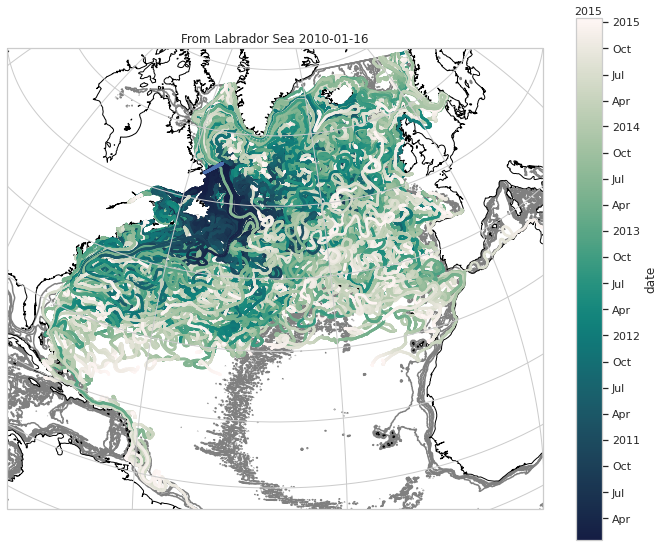

In [49]:
plotTracksCartopy(ds_select,
                  cmap=co.cm.tempo_r,
                  title='From Labrador Sea '+date,
                  fig_path = project_path / figures_path, 
                  fileroot='Lab',date=date)

In [65]:
test = ds_e60.isel(traj=slice(0,None,1))
ds_select = test.where(test.isel(obs=0).time == t[0]).dropna('traj', how='all').compute()

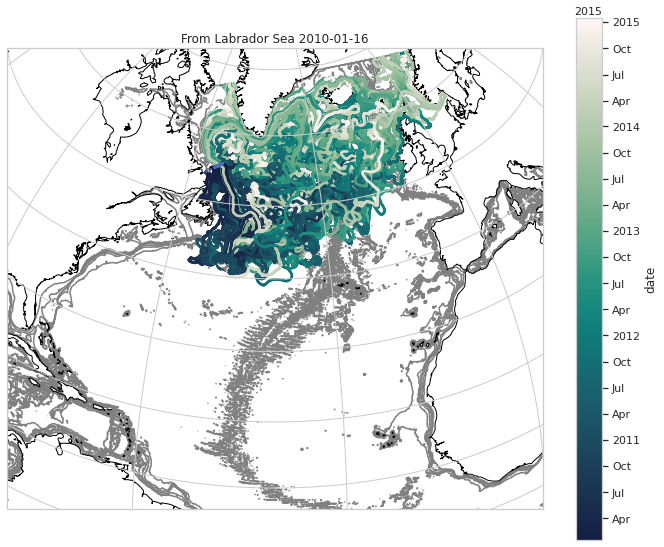

In [66]:
plotTracksCartopy(ds_select,
                  cmap=co.cm.tempo_r,
                  title='From Labrador Sea '+date,
                  fig_path = project_path / figures_path, 
                  fileroot='Lab',date=date)

In [46]:
test = ds_stg.isel(traj=slice(0,None,1))
ds_select = test.where(test.isel(obs=0).time == t[0]).dropna('traj', how='all').compute()

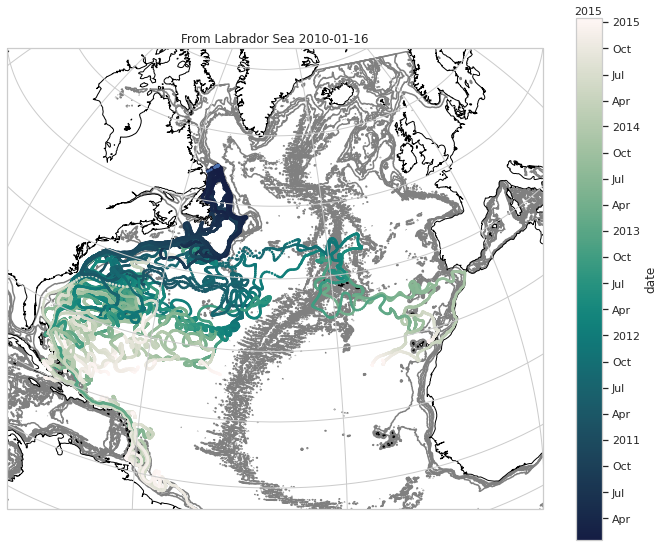

In [47]:
plotTracksCartopy(ds_select,
                  cmap=co.cm.tempo_r,
                  title='From Labrador Sea '+date,
                  fig_path = project_path / figures_path, 
                  fileroot='Lab',date=date)

In [67]:
def plot_transports_by_source(ds_i_all,ds_i_spg,ds_i_stg,ds_i_oth):

    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(5,figsize = (9,15),sharex=True)

    ds_i_all.groupby("time").sum().vol_trans_normal.plot(ax=ax[0],label='total')
    ds_i_spg.groupby("time").sum().vol_trans_normal.plot(ax=ax[0],label='spg')
    ds_i_stg.groupby("time").sum().vol_trans_normal.plot(ax=ax[0],label='stg')
    ds_i_oth.groupby("time").sum().vol_trans_normal.plot(ax=ax[0],label='other')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')
    ax[0].set_ylim(bottom=0)

    ds_i_all.groupby("time").sum().temp_transport.plot(ax=ax[1],label='total')
    ds_i_spg.groupby("time").sum().temp_transport.plot(ax=ax[1],label='spg')
    ds_i_stg.groupby("time").sum().temp_transport.plot(ax=ax[1],label='stg')
    ds_i_oth.groupby("time").sum().temp_transport.plot(ax=ax[1],label='other')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('temperature transport [Sv $\degree$C]')
    ax[1].set_xlabel('')
    ax[1].set_ylim(bottom=0)

    ds_i_all.groupby("time").sum().salt_transport.plot(ax=ax[2],label='total')
    ds_i_spg.groupby("time").sum().salt_transport.plot(ax=ax[2],label='spg')
    ds_i_stg.groupby("time").sum().salt_transport.plot(ax=ax[2],label='stg')
    ds_i_oth.groupby("time").sum().salt_transport.plot(ax=ax[2],label='other')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('salt transport [Sv PSU]')
    ax[2].set_ylim(bottom=0)

    ds_i_all.groupby("time").sum().particle_vol.plot(ax=ax[3],label='total')
    ds_i_spg.groupby("time").sum().particle_vol.plot(ax=ax[3],label='spg')
    ds_i_stg.groupby("time").sum().particle_vol.plot(ax=ax[3],label='stg')
    ds_i_oth.groupby("time").sum().particle_vol.plot(ax=ax[3],label='other')
    ax[3].legend(bbox_to_anchor=(1.0, 1.05))
    ax[3].set_ylabel('volume [$m^3 x 10^6$]')
    ax[3].set_xlabel('')
    ax[3].set_ylim(bottom=0)

    (ds_i_all.groupby("time").sum().vol_trans_normal
     /ds_i_all.groupby("time").sum().particle_vol).plot(ax=ax[4],label='total')
    (ds_i_spg.groupby("time").sum().vol_trans_normal
     /ds_i_spg.groupby("time").sum().particle_vol).plot(ax=ax[4],label='spg')
    (ds_i_stg.groupby("time").sum().vol_trans_normal
     /ds_i_stg.groupby("time").sum().particle_vol).plot(ax=ax[4],label='stg')
    (ds_i_oth.groupby("time").sum().vol_trans_normal
     /ds_i_oth.groupby("time").sum().particle_vol).plot(ax=ax[4],label='other')
    ax[4].legend(bbox_to_anchor=(1.0, 1.05))
    ax[4].set_ylabel('average u_normal [$m s^{-1}$]')
    ax[4].set_xlabel('')
    ax[4].set_ylim(bottom=0)


    title=fig.suptitle('Volumes and transports in Gulf Stream by destination.')
    
#     plt.savefig('plot_transports_by_source.eps', 
#                 bbox_extra_artists=(lgd,title), bbox_inches='tight')
    plt.savefig('gs_plot_transports_by_destination.png', 
                bbox_extra_artists=(lgd,title), bbox_inches='tight')
#     plt.savefig('plot_transports_by_source.pdf', 
#                 bbox_extra_artists=(lgd,title), bbox_inches='tight')
    
    
    return


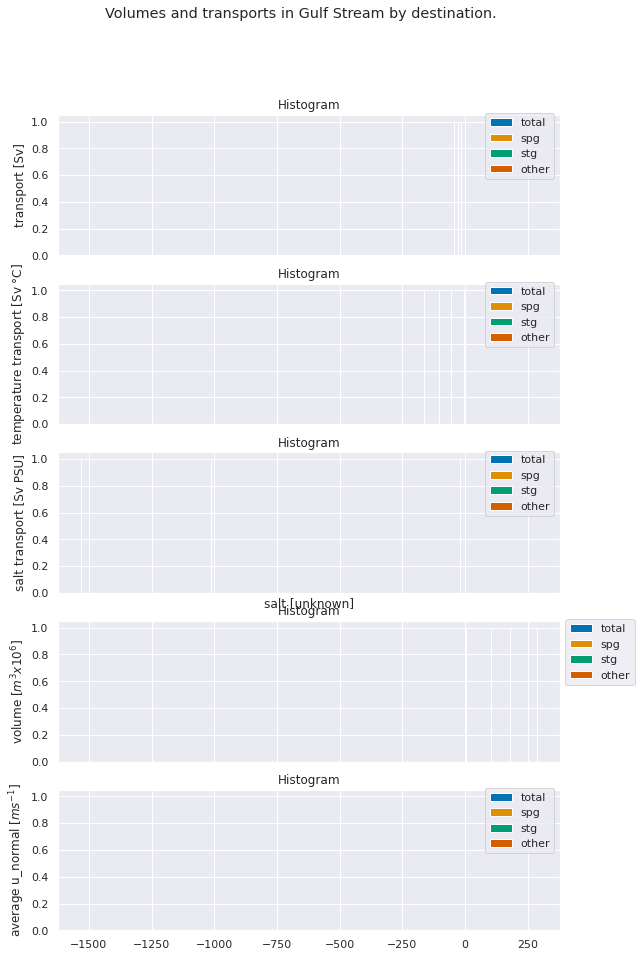

In [68]:
plot_transports_by_source(ds_init,ds_init_spg,ds_init_stg,ds_init_other)

In [85]:
def plot_section_sdist(ds_i_all,ds_i_spg,ds_i_60w,ds_i_e60,ds_i_stg,ds_i_oth):
    fig,ax = plt.subplots(6,figsize=(10,12),sharex=True)

    
    ax[0].scatter(
        ds_i_all.x,
        ds_i_all.z,
        0.1,
        c = 'C0'
    )
    ax[1].scatter(
        ds_i_all.x,
        ds_i_all.z,
        0.1,
        c = 'C0'
    )
    ax[1].scatter(
        ds_i_spg.x,
        ds_i_spg.z,
        0.1,
        c = 'C1'
    )
    ax[2].scatter(
        ds_i_60w.x,
        ds_i_60w.z,
        0.1,
        c = 'C2'
    )
    ax[3].scatter(
        ds_i_e60.x,
        ds_i_e60.z,
        0.1,
        c = 'C3'
    )
    ax[4].scatter(
        ds_i_stg.x,
        ds_i_stg.z,
        0.1,
        c = 'C4'
    )
    ax[5].scatter(
        ds_i_all.x,
        ds_i_all.z,
        0.1,
        c = 'C0'
    )
    ax[5].scatter(
        ds_i_oth.x,
        ds_i_oth.z,
        0.1,
        c = 'C5'
    )
    ax[0].set_ylim(3500,0)
    ax[1].set_ylim(3500,0)
    ax[2].set_ylim(3500,0)
    ax[3].set_ylim(3500,0)
    ax[4].set_ylim(3500,0)
    ax[5].set_ylim(3500,0)
    ax[0].set_xlim(right=420)
    ax[1].set_xlim(right=420)
    ax[2].set_xlim(right=420)
    ax[3].set_xlim(right=420)
    ax[4].set_xlim(right=420)
    ax[5].set_xlim(right=420)
    return



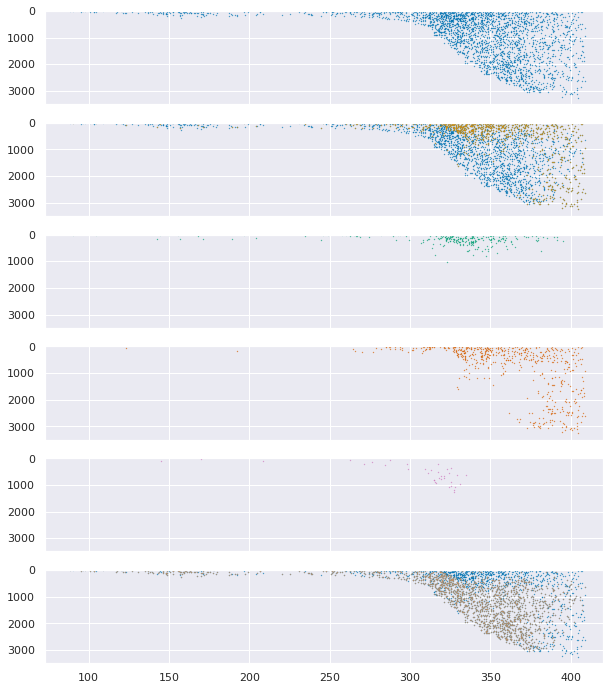

In [86]:
plot_section_sdist(ds_init.where(ds_init.time==t[0]),
                   ds_init_spg.where(ds_init_spg.time==t[0]),
                   ds_init_60w.where(ds_init_60w.time==t[0]),
                   ds_init_e60.where(ds_init_e60.time==t[0]),
                   ds_init_stg.where(ds_init_stg.time==t[0]),
                   ds_init_other.where(ds_init_other.time==t[0]))

In [31]:
conda list

# packages in environment at /opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                      1_llvm    conda-forge
ansiwrap                  0.8.4                      py_0    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
argon2-cffi               20.1.0           py38h497a2fe_2    conda-forge
asciitree                 0.3.3                      py_2    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     20.3.0             pyhd3deb0d_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.1                      py_0    conda-forge
basemap                   1.2.2      

In [20]:
# pip list